Provided example uses toy data. You can access the real [UK travel survey from 2002-2021](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340) from the [UK Data Service](https://beta.ukdataservice.ac.uk).

In [ ]:
from pathlib import Path

import networkx as nx
import matplotlib.pyplot as plt

from ntsx import load, core, ops
from ntsx.plot import plot

In [ ]:
# load dummy data (synthesised from UK NTS)

dir = Path("data/dummyNTS/")
trips_csv = dir / "trips.tab"
attributes_csv = dir / "individuals.tab"
hhs_csv = dir / "households.tab"

years = [2021]

write_dir = Path("tmp")
write_dir.mkdir(exist_ok=True)

In [3]:
trips = load.trips(trips_csv, years=years)
trips.head(10)

,tid,year,day,iid,hid,seq,mode,oact,dact,freq,tst,tet,ozone,dzone,did,pid
0,1,2021,2,1,1,1,car,home,social,0.989618,675,683,7,7,1,1_1
1,2,2021,2,1,1,2,car,social,other,1.002945,720,735,7,7,1,1_1
2,3,2021,2,1,1,3,car,other,social,0.989618,770,780,7,7,1,1_1
3,4,2021,2,1,1,4,taxi,social,home,0.989618,1110,1130,7,7,1,1_1
4,5,2021,3,1,1,1,car,home,social,0.999891,760,770,7,7,2,1_1
5,6,2021,3,1,1,2,car,social,social,0.999891,790,805,7,7,2,1_1
6,7,2021,3,1,1,3,car,social,other,1.061665,810,825,7,7,2,1_1
7,8,2021,3,1,1,4,car,other,other,1.061665,845,852,7,7,2,1_1
8,9,2021,3,1,1,5,car,other,social,0.999891,865,873,7,7,2,1_1
9,10,2021,3,1,1,6,car,social,escort,1.006313,908,914,7,7,2,1_1


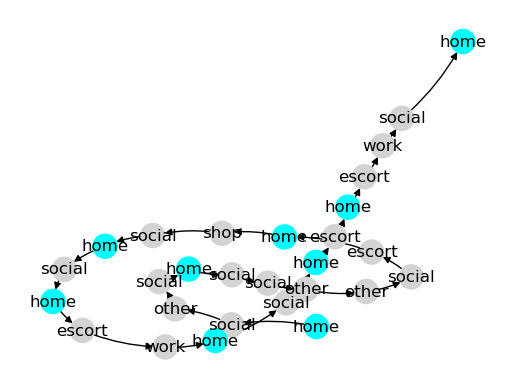

In [4]:
# load  the first persons trips into nx
iid = 1
g = core.to_nx(trips.loc[trips.iid == iid])
plot(g)

Could not find any education activities.


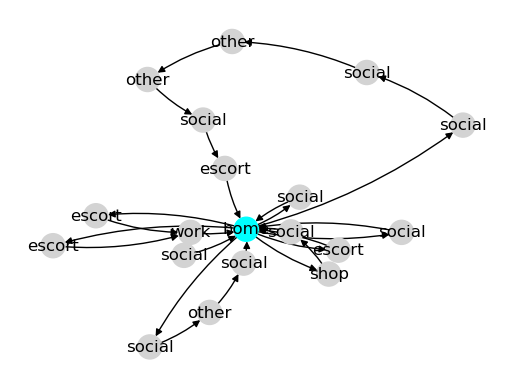

In [5]:
# nodes/vertices represent facilities for activities (they have a type eg "work" and an approx location)
# edges represent trips between activities (they have a mode eg "car", a start time and a duration)
# first we combine facilities (nodes) based on a given list of "anchor" activities

g_anchored = ops.anchor_activities(g, ["home", "work", "education"])
plot(g_anchored)

Contacting; 26 and 19
Contacting; 7 and 17
Contacting; 7 and 28


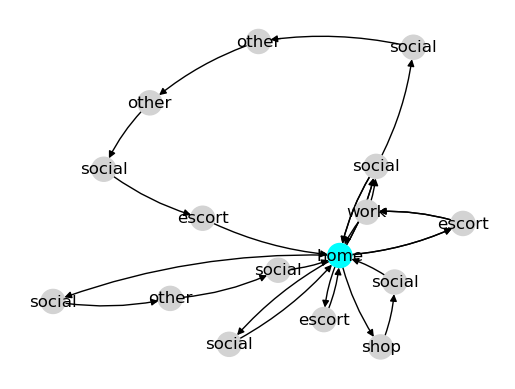

In [6]:
# now we merge similar looking facilities beyond the anchors
# we do this by iteratively searching facilities breadth first from the home facility
# for each facility we condider all pairs of trips (in and out)
# if the trips are similar and come from similar looking facilities we merge the facilities
# Facility similarity is based on a facility having the same activity typpe and zone
# Trip similarity is based on the trip mode being the same and the duration being similar

merged_g = ops.merge_similar(g_anchored, duration_tolerance=0.2, verbose=True)
plot(merged_g)

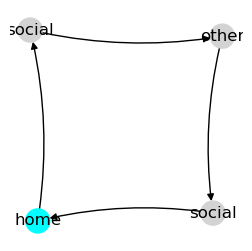

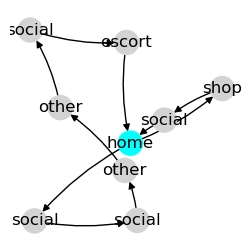

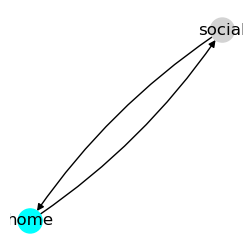

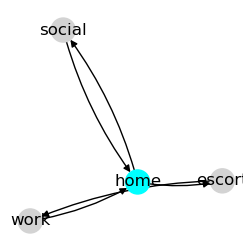

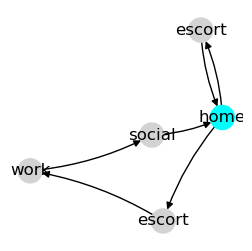

In [7]:
# We can split the graph back into days:
for day, g in ops.iter_days(merged_g):
    plot(g, figsize=(3, 3))

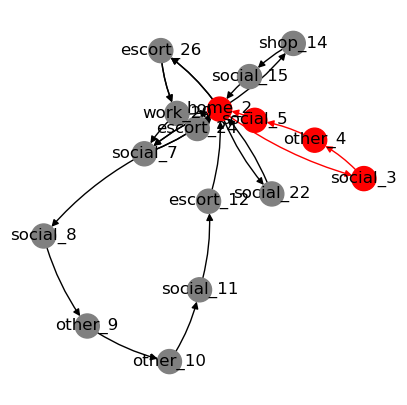

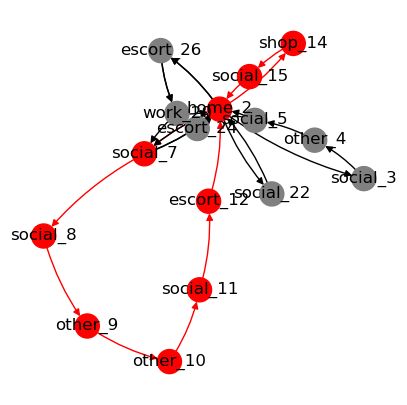

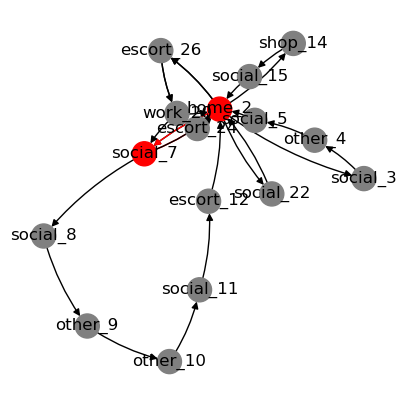

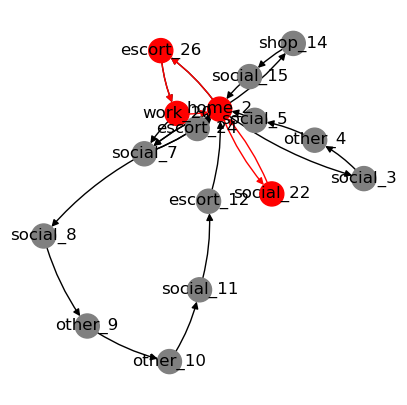

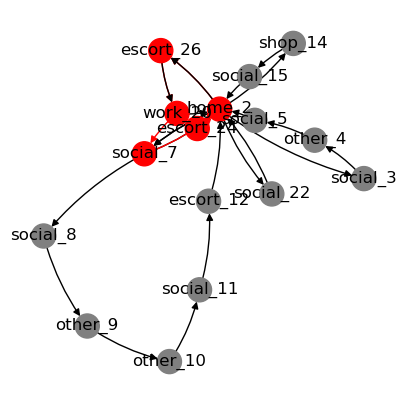

In [8]:
# we can also create a boolean mask for edges
# in this case we demo a mask for each day

positions = nx.spring_layout(merged_g, weight="duration", seed=12345)
acts = {i: f"{node.get("act")}_{i}" for i, node in merged_g.nodes(data=True)}

for day, g in ops.iter_days_masked(merged_g):
    masked_edges = [
        (u, v, k) for u, v, k in g.edges(keys=True) if g[u][v][k].get("masked")
    ]
    masked_nodes = set([u for u, _, _ in masked_edges]) | set(
        [v for _, v, _ in masked_edges]
    )
    edge_colors = [
        "red" if g[u][v][k].get("masked") else "black" for u, v, k in g.edges(keys=True)
    ]
    node_colors = ["red" if n in masked_nodes else "grey" for n in g.nodes]

    fig, ax = plt.subplots(figsize=(5, 5))
    nx.draw(
        g,
        positions,
        labels=acts,
        with_labels=True,
        connectionstyle="arc3,rad=0.1",
        ax=ax,
        edge_color=edge_colors,
        node_color=node_colors,
    )

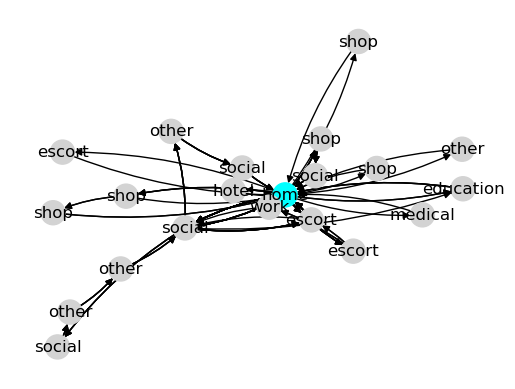

In [9]:
# we can repeat above for multiple persons
# load in first 1000 trips and combine them into a single graph

gs = core.to_nx(trips.head(1000))
gs = ops.anchor_activities(gs, ["home", "work", "education"])
gs = ops.merge_similar(gs, duration_tolerance=0.2)
plot(gs)

/home/fred/Projects/ntsx/ntsx/plot.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(**kwargs)


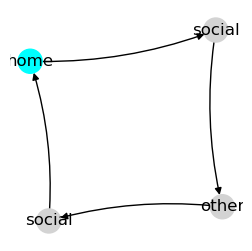

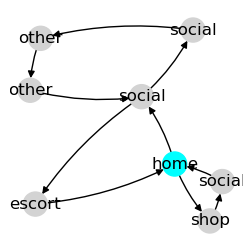

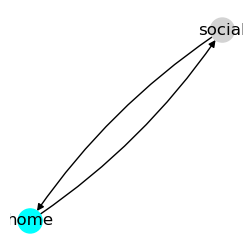

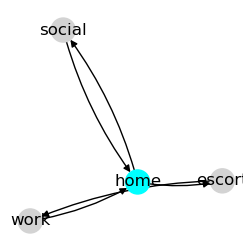

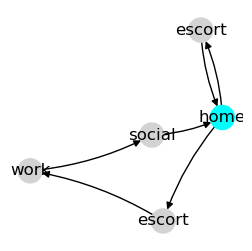

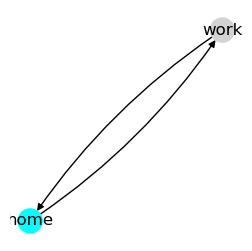

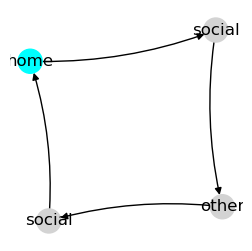

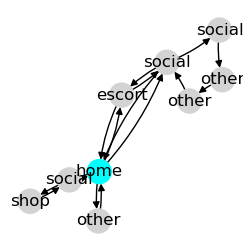

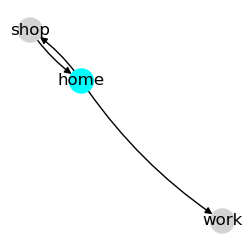

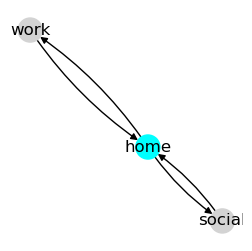

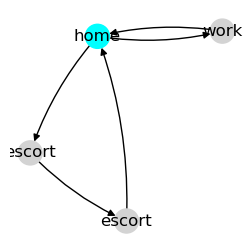

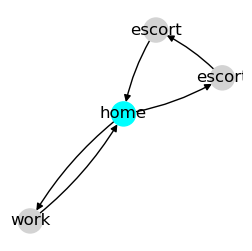

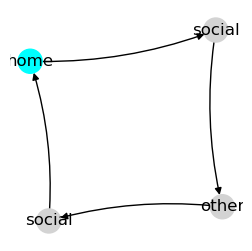

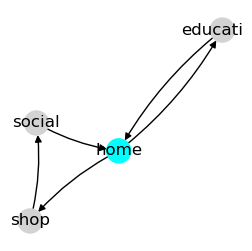

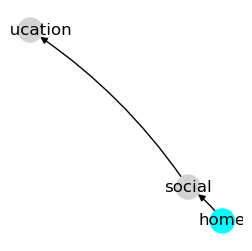

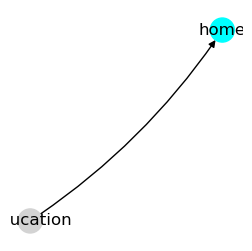

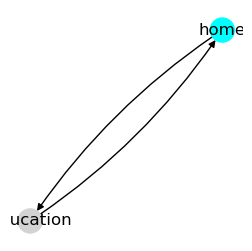

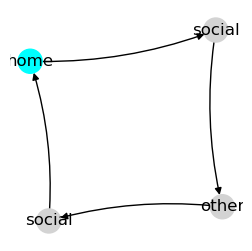

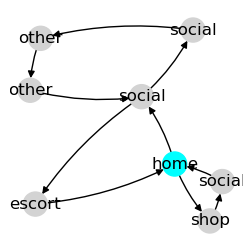

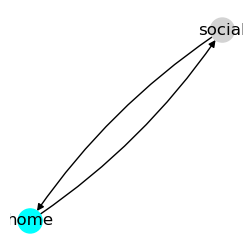

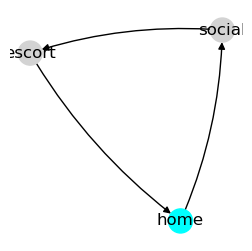

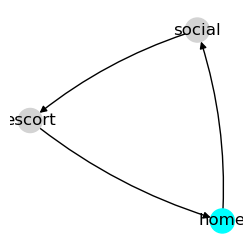

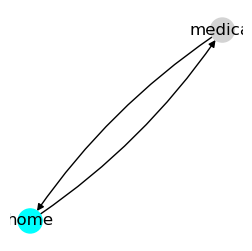

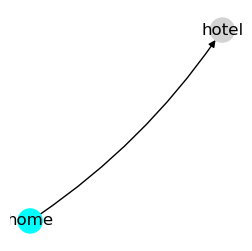

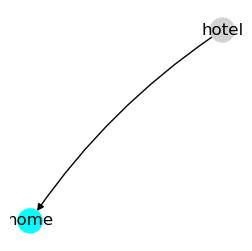

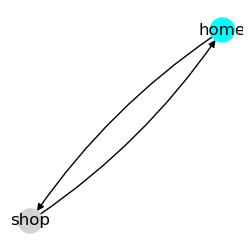

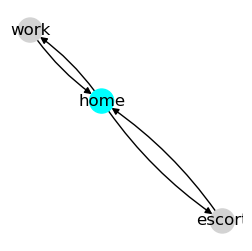

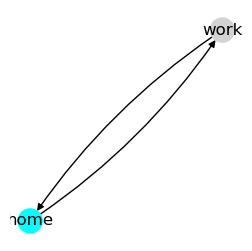

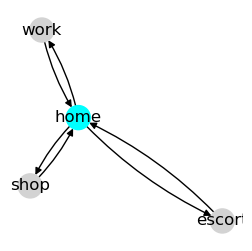

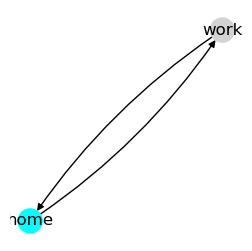

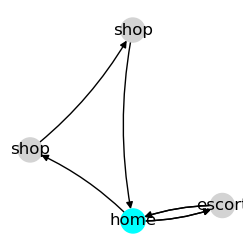

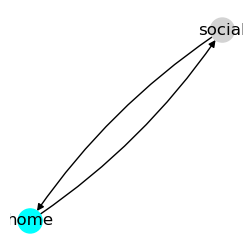

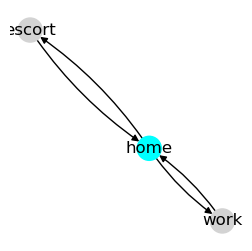

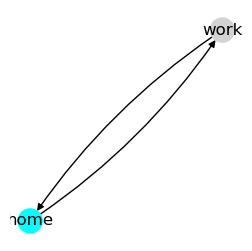

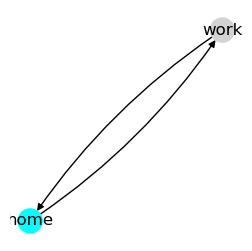

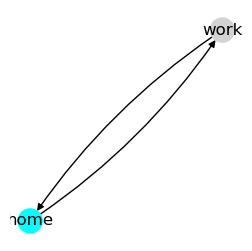

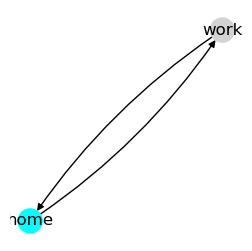

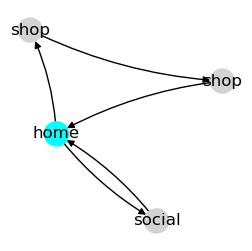

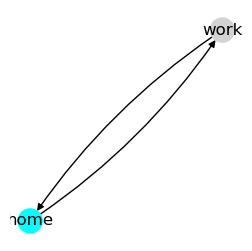

In [10]:
for day, g in ops.iter_days(gs):
    plot(g, figsize=(3, 3))